## Introduction
Kaggle에 있는 도큐멘팅문서를 이해하는 것을 목적으로 작성된 문서임.또한 해당 문서에 대한 번역도 포함함. https://www.kaggle.com/jeffd23/scikit-learn-ml-from-start-to-finish?scriptVersionId=320209
    
## Machine Leaning from Start to Finish with Scikit-Learn
이 노트북에서는 기본적인 Machine Learning process에 대해 파이썬을 통해 step-by-step으로 설명합니다. 
Titanic Survivors dataset의 raw데이터에서 78%의 정확도로 향상해봅시다.
(역자 설명: Kaggle에 Titanic Survivors라는 competittion이 있음. 간단히 말하면, 타이타닉 사건의 생존자 데이터로 부터 생존예측을 하는 대회임.) 

## Steps Covered
  1. DataFrame을 import해보기
  2. 데이터 시각화
  3. 데이터 정제 및 변환
  4. 데이터 인코딩
  5. Training Sets과 Test Sets를 분리
  6. Fine Tune Algorithms
  7. KFold를 통한 교차 검증
  8. 캐글에 업로드 하기 

## CSV to DataFrame
CSV 파일은 pd.read_csv로 읽어서 DataFrame에 로드할수있습니다.
training파일과 test파일을 로드한후 랜덤하게 print 하여 작업하는 내용을 확인합니다.

In [2]:
# 주로 배열, 벡터, 선형대수를 다룰때 자주 사용함. 
import numpy as np  

# 데이터를 마치 엑셀과 같이 다룰수 있게 도와주는 라이브러리
import pandas as pd 

# 데이터 시각화에 굉장히 유용한 라이브러리
import matplotlib.pyplot as plt
import seaborn as sns 

# 경고창 무시
import warnings
warnings.filterwarnings('ignore')

#해당 명령어를 입력해야 그래프를 그릴수있음
%matplotlib inline 

data_train = pd.read_csv('./train.csv')
data_test = pd.read_csv('./test.csv')

data_train.sample(3)

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
879,880,1,1,"Potter, Mrs. Thomas Jr (Lily Alexenia Wilson)",female,56.0,0,1,11767,83.1583,C50,C
888,889,0,3,"Johnston, Miss. Catherine Helen ""Carrie""",female,NaN,1,2,W./C. 6607,23.4500,NaN,S
167,168,0,3,"Skoog, Mrs. William (Anna Bernhardina Karlsson)",female,45.0,1,4,347088,27.9000,NaN,S


## 데이터 시각화
데이터를 시각화하는 것은 모델에서 활용하기 위한 기본적인 패턴은 찾기위해 매우 중요합니다.

In [1]:
#sns.barplot(x="Fare", y="Survived", hue="Sex", data=data_train);
sns.barplot(x="Age", y="Survived", hue="Sex",
            data=data_train);

NameError: name 'sns' is not defined

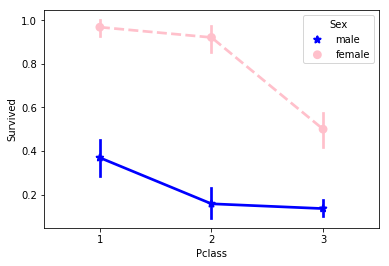

In [56]:
sns.pointplot(x="Pclass", y="Survived", hue="Sex", 
              data=data_train, palette={"male": "blue", 
                                        "female":"pink"},
              markers=["*", "o"], linestyles=["-","--"])

## Transforming Features
  1. 'Sex'를 제외하고 'Age' Feature는 두번째로 중요합니다. 
      Overfitting을 피하기 위해 사람들을 logical human age   
      groups로 분류하였다.
  2. 'Cabin'은 글자 하나로 시작한다. 이 글자는 뒤따르는 숫자
      보다 중요하다는것을 확신하고, 그 숫자를 잘라버립시다.
  3. 'Fare'는 단순화되어야할 연속 변수입니다.
      저는 data_train.Fare.describe()를 실행하여 해당 Feature
      의 분포를 얻고, 그에따라 quartile bins에 놓았습니다.
  4. 'Name' Feature에서 정보를 뽑아봅시다. Full name을 사용
      하는 대신에 last name이나 name prefix(Mr, Mrs, etc)을 
      추출하여 그들의 Feature에 추가하였다.
  5. 마지막으로, 쓸모없는 Features는 버려라. (Ticket, Name)

In [4]:
def simplify_ages(df):
    df.Age = df.Age.fillna(-0.5)
    bins = (-1, 0, 5, 12, 18, 25, 35, 60, 120)
    group_names = ['Unknown', 'Baby', 'Child', 'Teenager', 'Student', 'Young Adult', 'Adult', 'Senior']
    categories = pd.cut(df.Age, bins, labels=group_names)
    df.Age = categories
    return df

def simplify_cabins(df):
    df.Cabin = df.Cabin.fillna('N')
    df.Cabin = df.Cabin.apply(lambda x: x[0])
    return df

def simplify_fares(df):
    df.Fare = df.Fare.fillna(-0.5)
    bins = (-1, 0, 8, 15, 31, 1000)
    group_names = ['Unknown', '1_quartile', '2_quartile', '3_quartile', '4_quartile']
    categories = pd.cut(df.Fare, bins, labels=group_names)
    df.Fare = categories
    return df

def format_name(df):
    df['Lname'] = df.Name.apply(lambda x: x.split(' ')[0])
    df['NamePrefix'] = df.Name.apply(lambda x: x.split(' ')[1])
    return df    
    
def drop_features(df):
    return df.drop(['Ticket', 'Name', 'Embarked'], axis=1)

def transform_features(df):
    df = simplify_ages(df)
    df = simplify_cabins(df)
    df = simplify_fares(df)
    df = format_name(df)
    df = drop_features(df)
    return df

data_train = transform_features(data_train)
data_test = transform_features(data_test)
data_train.head()

,PassengerId,Survived,Pclass,Sex,Age,SibSp,Parch,Fare,Cabin,Lname,NamePrefix
0,1,0,3,male,Student,1,0,1_quartile,N,"Braund,",Mr.
1,2,1,1,female,Adult,1,0,4_quartile,C,"Cumings,",Mrs.
2,3,1,3,female,Young Adult,0,0,1_quartile,N,"Heikkinen,",Miss.
3,4,1,1,female,Young Adult,1,0,4_quartile,C,"Futrelle,",Mrs.
4,5,0,3,male,Young Adult,0,0,2_quartile,N,"Allen,",Mr.


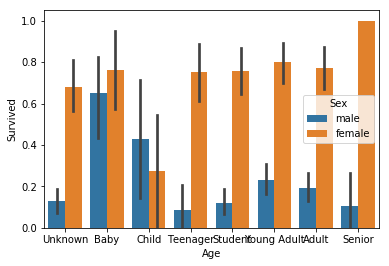

In [5]:
sns.barplot(x="Age", y="Survived", hue="Sex", 
            data=data_train);

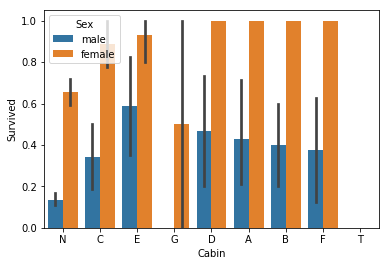

In [59]:
sns.barplot(x="Cabin", y="Survived", hue="Sex", 
            data=data_train)

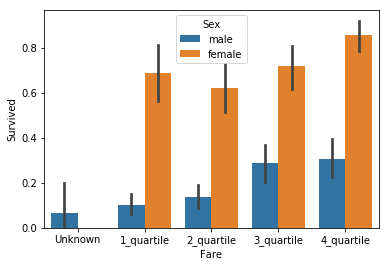

In [60]:
sns.barplot(x="Fare", y="Survived", hue="Sex",
           data=data_train)

## Some Final Encoding
전처리 단계의 마지막 단계는 label들을 nomalize하는 것이다. 
Scikit-Learn의 LabelEncoder는 다양한 알고리즘에 적용할 수 
있도록 각 고유한 문자열 값을 숫자로 변환한다.

그런 결과는 인간에게는 무섭게 보이는 숫자 표이지만, 기계에게는 아름답게 보이는 숫자 표입니다.

In [61]:
from sklearn import preprocessing

def encode_features(df_train, df_test):
    features = ['Fare', 'Cabin', 'Age', 'Sex', 'Lname', 'NamePrefix']
    df_combined = pd.concat([df_train[features], df_test[features]])
    
    for feature in features:
        le = preprocessing.LabelEncoder()
        le = le.fit(df_combined[feature])
        df_train[feature] = le.transform(df_train[feature])
        df_test[feature] = le.transform(df_test[feature])
    return df_train, df_test
    
data_train, data_test = encode_features(data_train, data_test)
data_train.head()


,PassengerId,Survived,Pclass,Sex,Age,SibSp,Parch,Fare,Cabin,Lname,NamePrefix
0,1,0,3,1,4,1,0,0,7,100,19
1,2,1,1,0,0,1,0,3,2,182,20
2,3,1,3,0,7,0,0,0,7,329,16
3,4,1,1,0,7,1,0,3,2,267,20
4,5,0,3,1,7,0,0,1,7,15,19


## Splitting up the Training Data
이제 Machine Learning을 시작해봅시다. 

첫째로,features(x)를 labels(y)로부터 분리합니다. 

X_all: All features minus the value we want to predict (Survived).

y_all: 오직 우리가 예측하길 원하는 값

두번째로, Scikit-Learn을 사용하여 이 데이터를 무작위로 네가지의 변수로 섞습니다. 이 경우에는 80%의 데이터를 training하고 
나머지 20%에 대해서도 테스트 하고 있습니다.

이후에 이 데이터는 훈련된 알고리즘의 유효성을 검증하기 위해,
KFold 패턴으로 재구성 될것입니다.

In [62]:
from sklearn.model_selection import train_test_split

X_all = data_train.drop(['Survived', 'PassengerId'], axis=1)
y_all = data_train['Survived']

num_test = 0.20
X_train, X_test, y_train, y_test = train_test_split(X_all, y_all, test_size=num_test, random_state=23)

## Fitting and Tuning an Algorithm
이제 어떤 알고리즘이 가장 좋은 모델을 제공하는지 알아보겠습니다. 저는 RandomForestClassifier를 사용하고 있지만, SupportVectorMachine이나 NaiveBayes와 같은 Classifier를 사용할수도 있다.

In [63]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import make_scorer, accuracy_score
from sklearn.model_selection import GridSearchCV

# Choose the type of classifier. 
clf = RandomForestClassifier()

# Choose some parameter combinations to try
parameters = {'n_estimators': [4, 6, 9], 
              'max_features': ['log2', 'sqrt','auto'], 
              'criterion': ['entropy', 'gini'],
              'max_depth': [2, 3, 5, 10], 
              'min_samples_split': [2, 3, 5],
              'min_samples_leaf': [1,5,8]
             }

# Type of scoring used to compare parameter combinations
acc_scorer = make_scorer(accuracy_score)

# Run the grid search
grid_obj = GridSearchCV(clf, parameters, scoring=acc_scorer)
grid_obj = grid_obj.fit(X_train, y_train)

# Set the clf to the best combination of parameters
clf = grid_obj.best_estimator_

# Fit the best algorithm to the data. 
clf.fit(X_train, y_train)

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=10, max_features='sqrt', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=5,
            min_weight_fraction_leaf=0.0, n_estimators=9, n_jobs=1,
            oob_score=False, random_state=None, verbose=0,
            warm_start=False)

In [64]:
predictions = clf.predict(X_test)
print(accuracy_score(y_test, predictions))

0.8379888268156425


## KFold를 통한 검증
이 모델이 실제로 좋은 점이 있나요? 그것은 KFold를 이용한 알고리즘의 효과를 입증하는데 도움이 됩니다. 그러면 데이터가 10개의 bucket으로 분할되고 다른 bucket을 사용하여 알고리즘이 각 반복에 대한 테스트 세트로 실행됩니다.

In [65]:
from sklearn.cross_validation import KFold

def run_kfold(clf):
    kf = KFold(891, n_folds=10)
    outcomes = []
    fold = 0
    for train_index, test_index in kf:
        fold += 1
        
        # X_all, y_all은 전역 변수이다.
        X_train, X_test = X_all.values[train_index], X_all.values[test_index]
        y_train, y_test = y_all.values[train_index], y_all.values[test_index]
        clf.fit(X_train, y_train)
        predictions = clf.predict(X_test)
        accuracy = accuracy_score(y_test, predictions)
        outcomes.append(accuracy)
        print("Fold {0} accuracy: {1}".format(fold, accuracy))     
    mean_outcome = np.mean(outcomes)
    print("Mean Accuracy: {0}".format(mean_outcome)) 

run_kfold(clf)

Fold 1 accuracy: 0.7666666666666667
Fold 2 accuracy: 0.898876404494382
Fold 3 accuracy: 0.797752808988764
Fold 4 accuracy: 0.8426966292134831
Fold 5 accuracy: 0.8202247191011236
Fold 6 accuracy: 0.8314606741573034
Fold 7 accuracy: 0.7865168539325843
Fold 8 accuracy: 0.8202247191011236
Fold 9 accuracy: 0.8764044943820225
Fold 10 accuracy: 0.8202247191011236
Mean Accuracy: 0.8261048689138576


## Predict the Actual Test Data
예측을 수행하고 CSV를 내보내기한후에 Kaggle에 업로드 합니다.

In [67]:
ids = data_test['PassengerId']
predictions = clf.predict(data_test.drop('PassengerId', axis=1))

output = pd.DataFrame({ 'PassengerId' : ids, 'Survived': predictions })
output.to_csv('titanic-predictions.csv', index = False)
output.head()

,PassengerId,Survived
0,892,0
1,893,0
2,894,0
3,895,0
4,896,1
